In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

for path, dirs, files in os.walk("/content/drive/MyDrive"):
    print(path)


/content/drive/MyDrive
/content/drive/MyDrive/rdfia
/content/drive/MyDrive/rdfia/sift
/content/drive/MyDrive/rdfia/sift/CALsuburb
/content/drive/MyDrive/rdfia/sift/MITcoast
/content/drive/MyDrive/rdfia/sift/MITforest
/content/drive/MyDrive/rdfia/sift/MIThighway
/content/drive/MyDrive/rdfia/sift/MITinsidecity
/content/drive/MyDrive/rdfia/sift/MITmountain
/content/drive/MyDrive/rdfia/sift/MITopencountry
/content/drive/MyDrive/rdfia/sift/MITstreet
/content/drive/MyDrive/rdfia/sift/MITtallbuilding
/content/drive/MyDrive/rdfia/sift/PARoffice
/content/drive/MyDrive/rdfia/sift/bedroom
/content/drive/MyDrive/rdfia/sift/industrial
/content/drive/MyDrive/rdfia/sift/kitchen
/content/drive/MyDrive/rdfia/sift/livingroom
/content/drive/MyDrive/rdfia/sift/store
/content/drive/MyDrive/rdfia/kmeans
/content/drive/MyDrive/Assignment1
/content/drive/MyDrive/Assignment1/.idea
/content/drive/MyDrive/Assignment1/.idea/inspectionProfiles
/content/drive/MyDrive/ANN (1)
/content/drive/MyDrive/ANN (1)/LAB1
/con

In [ ]:
import os

base_path = "/content/drive/MyDrive/data_genhack"  # adjust name
for root, dirs, files in os.walk(base_path):
    print(root)
    for f in files:
        print("   ", f)


/content/drive/MyDrive/data_genhack
/content/drive/MyDrive/data_genhack/main
    ECA_blend_tx.zip
    gadm_410_europe.gpkg
    read-era5-netcdf_v2.ipynb
    GenHack - Kayrros data User Guide.gdoc
/content/drive/MyDrive/data_genhack/main/derived-era5-land-daily-statistics
    2021_10m_v_component_of_wind_daily_mean.nc
    2021_10m_u_component_of_wind_daily_mean.nc
    2020_10m_v_component_of_wind_daily_mean.nc
    2020_2m_temperature_daily_maximum.nc
    2020_10m_u_component_of_wind_daily_mean.nc
    2022_2m_temperature_daily_maximum.nc
    2022_10m_v_component_of_wind_daily_mean.nc
    2023_10m_u_component_of_wind_daily_mean.nc
    2022_10m_u_component_of_wind_daily_mean.nc
    2021_2m_temperature_daily_maximum.nc
    2023_2m_temperature_daily_maximum.nc
    2025_10m_u_component_of_wind_daily_mean.nc
    2024_2m_temperature_daily_maximum.nc
    2024_10m_u_component_of_wind_daily_mean.nc
    2025_2m_temperature_daily_maximum.nc
    2023_10m_v_component_of_wind_daily_mean.nc
    2025_10m

In [ ]:
import os
import zipfile
import numpy as np
import pandas as pd
import xarray as xr
import rasterio
from rasterio.warp import transform
import geopandas as gpd
import matplotlib.pyplot as plt

base_main = "/content/drive/MyDrive/data_genhack/main"
era5_dir = os.path.join(base_main, "derived-era5-land-daily-statistics")
ndvi_dir = os.path.join(base_main, "sentinel2_ndvi")
eca_zip = os.path.join(base_main, "ECA_blend_tx.zip")
gadm_path = os.path.join(base_main, "gadm_410_europe.gpkg")  # per confini, se serve


Reading stations metadata

In [ ]:
# path sul drive dove sta lo zip
eca_zip = "/content/drive/MyDrive/data_genhack/main/ECA_blend_tx.zip"

# directory locale (scrivibile)
eca_dir = "/content/eca_unzip"
os.makedirs(eca_dir, exist_ok=True)

with zipfile.ZipFile(eca_zip, 'r') as zf:
    zf.extractall(eca_dir)

print(os.listdir(eca_dir)[:10])


['TX_STAID025690.txt', 'TX_STAID002971.txt', 'TX_STAID024778.txt', 'TX_STAID000951.txt', 'TX_STAID024731.txt', 'TX_STAID027829.txt', 'TX_STAID025836.txt', 'TX_STAID025612.txt', 'TX_STAID024834.txt', 'TX_STAID018055.txt']


In [ ]:
stations_path = os.path.join(eca_dir, "stations.txt")

# trova il numero di riga dove inizia la tabella (cerca "STAID")
header_line = None
with open(stations_path, "r") as f:
    for i, line in enumerate(f):
        if line.strip().startswith("STAID"):
            header_line = i
            break

print("Header line at:", header_line)


Header line at: 17


In [ ]:
# leggi solo la riga di header (quella con STAID,STANAME,...)
with open(stations_path, "r") as f:
    for i, line in enumerate(f):
        if i == header_line:
            header_text = line.strip()
            break

print("Header text:", header_text)

colnames = [c.strip() for c in header_text.split(",")]
print("Column names:", colnames)


Header text: STAID,STANAME                                 ,CN,      LAT,       LON,HGHT
Column names: ['STAID', 'STANAME', 'CN', 'LAT', 'LON', 'HGHT']


In [ ]:
import pandas as pd

stations = pd.read_csv(
    stations_path,
    skiprows=header_line + 1,
    header=None,
    names=colnames,
    engine="python"
)

stations.head()


,STAID,STANAME,CN,LAT,LON,HGHT
0,1,VAEXJOE,SE,+56:52:00,+014:48:00,166
1,2,FALUN,SE,+60:37:00,+015:37:00,160
2,3,STENSELE,SE,+65:04:00,+017:09:59,325
3,4,LINKOEPING,SE,+58:24:00,+015:31:59,93
4,5,LINKOEPING-MALMSLAETT,SE,+58:24:00,+015:31:59,93


In [ ]:
stations = stations.rename(columns={
    "STAID": "station_id",
    "STANAME": "name",
    "LAT": "lat",
    "LON": "lon",
    "HGHT": "alt"
})
stations["station_id"] = stations["station_id"].astype(str).str.zfill(6)
stations.head()


,station_id,name,CN,lat,lon,alt
0,000001,VAEXJOE,SE,+56:52:00,+014:48:00,166
1,000002,FALUN,SE,+60:37:00,+015:37:00,160
2,000003,STENSELE,SE,+65:04:00,+017:09:59,325
3,000004,LINKOEPING,SE,+58:24:00,+015:31:59,93
4,000005,LINKOEPING-MALMSLAETT,SE,+58:24:00,+015:31:59,93


Helper functions for loading ERA5 Tmax (2m temperature daily max)

In [ ]:
def load_era5_tmax_year(year: int) -> xr.Dataset:
    path = os.path.join(
        era5_dir,
        f"{year}_2m_temperature_daily_maximum.nc"
    )
    ds = xr.open_dataset(path)
    # di solito la variabile si chiama 'mx2t' o simile: controlla
    print(ds)  # una volta per capire i nomi
    return ds


In [ ]:
era5_sample = load_era5_tmax_year(2020)
var_name = [v for v in era5_sample.data_vars][0]
print("ERA5 var:", var_name)


<xarray.Dataset> Size: 338MB
Dimensions:     (valid_time: 366, latitude: 350, longitude: 660)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 3kB 2020-01-01 ... 2020-12-31
  * latitude    (latitude) float64 3kB 69.9 69.8 69.7 69.6 ... 35.2 35.1 35.0
  * longitude   (longitude) float64 5kB -25.0 -24.9 -24.8 ... 40.7 40.8 40.9
    number      int64 8B ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 338MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-03T16:43 GRIB to CDM+CF via cfgrib-0.9.1...
ERA5 var: t2m


In [ ]:
def extract_era5_at_point(ds: xr.Dataset, lat, lon):
    """Restituisce una Series (indexed by time) con Tmax ERA5 per il punto lat/lon più vicino."""
    # sel con nearest
    point = ds[var_name].sel(latitude=lat, longitude=lon, method="nearest")
    # convertiamo a pandas.Series
    s = point.to_series()
    s.name = "t_era5"
    return s


Helper functions: NDVI Sentinel-2 for one station

In [ ]:
import datetime as dt
from dateutil.parser import parse as parse_date

# costruiamo un indice: (start_date, end_date, filepath)
ndvi_files = []
for fname in sorted(os.listdir(ndvi_dir)):
    if fname.endswith(".tif"):
        _, start_str, end_str = fname.replace(".tif", "").split("_")
        start = pd.to_datetime(start_str)
        end = pd.to_datetime(end_str)
        ndvi_files.append({
            "start": start,
            "end": end,
            "path": os.path.join(ndvi_dir, fname)
        })
ndvi_index = pd.DataFrame(ndvi_files)
ndvi_index.head()


,start,end,path
0,2019-12-01,2020-03-01,/content/drive/MyDrive/data_genhack/main/senti...
1,2020-03-01,2020-06-01,/content/drive/MyDrive/data_genhack/main/senti...
2,2020-06-01,2020-09-01,/content/drive/MyDrive/data_genhack/main/senti...
3,2020-09-01,2020-12-01,/content/drive/MyDrive/data_genhack/main/senti...
4,2020-12-01,2021-03-01,/content/drive/MyDrive/data_genhack/main/senti...


In [ ]:
def find_ndvi_file(date: pd.Timestamp):
    row = ndvi_index[(ndvi_index["start"] <= date) & (ndvi_index["end"] > date)]
    if row.empty:
        return None
    return row.iloc[0]["path"]


In [ ]:
from rasterio.warp import transform

def sample_ndvi_at_point(date: pd.Timestamp, lat: float, lon: float):
    tif_path = find_ndvi_file(date)
    if tif_path is None:
        return np.nan

    with rasterio.open(tif_path) as src:
        # coordinate nell'SRS del raster
        if src.crs.to_epsg() != 4326:
            xs, ys = transform("EPSG:4326", src.crs, [lon], [lat])
            x, y = xs[0], ys[0]
        else:
            x, y = lon, lat
        row, col = src.index(x, y)
        ndvi_val = src.read(1)[row, col]
        # spesso NDVI è scalato (es. int16 0–10000), controlla dalla doc
        return float(ndvi_val)


Building dataframe master for some stations/years

In [ ]:
import os

# trova un file TX per una qualsiasi stazione
for f in os.listdir(eca_dir):
    if f.startswith("TX_STAID") and f.endswith(".txt"):
        example_tx = os.path.join(eca_dir, f)
        print("Using example:", example_tx)
        break

# stampa le prime righe
with open(example_tx) as f:
    for i in range(20):
        print(f.readline().rstrip())


Using example: /content/eca_unzip/TX_STAID025690.txt
EUROPEAN CLIMATE ASSESSMENT & DATASET (ECA&D), file created on: 16-09-2025
THESE DATA CAN BE USED FOR NON-COMMERCIAL RESEARCH AND EDUCATION PROVIDED THAT THE FOLLOWING SOURCE IS ACKNOWLEDGED:

Klein Tank, A.M.G. and Coauthors, 2002. Daily dataset of 20th-century surface
air temperature and precipitation series for the European Climate Assessment.
Int. J. of Climatol., 22, 1441-1453.
Data and metadata available at http://www.ecad.eu

FILE FORMAT (MISSING VALUE CODE = -9999):

01-06 STAID: Station identifier
08-13 SOUID: Source identifier
15-22 DATE : Date YYYYMMDD
24-28 TX   : Maximum temperature in 0.1 &#176;C
30-34 Q_TX : quality code for TX (0='valid'; 1='suspect'; 9='missing')

This is the blended series of station VALLERMOSA, ITALY (STAID: 25690)
Blended and updated with sources:148095
See files sources.txt and stations.txt for more info.



In [ ]:
import pandas as pd

def load_station_tmax_series(station_id: str):
    """
    Legge un file TX_STAIDxxxxxx.txt dell’ECA&D
    e restituisce un DataFrame:
        date | t_station
    dove t_station è in °C.
    """
    # Nome del file dentro la cartella estratta
    fname = f"TX_STAID{station_id}.txt"
    fpath = os.path.join(eca_dir, fname)

    if not os.path.exists(fpath):
        raise FileNotFoundError(f"File not found: {fpath}")

    # Trova dove inizia la parte tabellare (la prima riga che comincia con un numero)
    start_line = None
    with open(fpath, "r") as f:
        for i, line in enumerate(f):
            if line[:6].strip().isdigit():   # STAID è nei caratteri 1–6
                start_line = i
                break

    if start_line is None:
        raise ValueError("No data section found in " + fpath)

    # Leggi la tabella con colspecs
    df = pd.read_fwf(
        fpath,
        skiprows=start_line,
        colspecs=[(0,6), (7,13), (14,22), (23,28), (29,34)],
        names=["STAID", "SOUID", "DATE", "TX", "Q_TX"]
    )

    # Converti date
    df["DATE"] = pd.to_datetime(df["DATE"], format="%Y%m%d", errors="coerce")

    # Converti temperatura (da decimi di °C → °C)
    df["t_station"] = df["TX"] / 10.0

    # filtra valori mancanti
    df = df[df["t_station"] > -999]   # -999.9 → missing

    # Teniamo solo le colonne che ci servono
    df = df[["DATE", "t_station"]].rename(columns={"DATE": "date"})

    return df


In [ ]:
test = load_station_tmax_series("018510")
test.head()


,date,t_station
13,2014-04-14,0.9
640,2016-01-01,-1.6
641,2016-01-02,-3.5
642,2016-01-03,-11.0
643,2016-01-04,-13.6


In [ ]:
print("Stations table shape:", stations.shape)
print(stations.head())
print(stations.columns)


Stations table shape: (8568, 6)
  station_id                                          name    CN        lat  \
0     000001  VAEXJOE                                       SE    +56:52:00   
1     000002  FALUN                                         SE    +60:37:00   
2     000003  STENSELE                                      SE    +65:04:00   
3     000004  LINKOEPING                                    SE    +58:24:00   
4     000005  LINKOEPING-MALMSLAETT                         SE    +58:24:00   

          lon  alt  
0  +014:48:00  166  
1  +015:37:00  160  
2  +017:09:59  325  
3  +015:31:59   93  
4  +015:31:59   93  
Index(['station_id', 'name', 'CN', 'lat', 'lon', 'alt'], dtype='object')


In [ ]:
import re

def dms_to_decimal_safe(dms_str):
    if isinstance(dms_str, float) or isinstance(dms_str, int):
        return float(dms_str)  # già convertito

    s = str(dms_str).strip()

    # match di tipo +44:17:43, -03:22:10, ecc.
    m = re.match(r"^([+-]?)(\d+):(\d+):(\d+(?:\.\d+)?)$", s)
    if not m:
        raise ValueError(f"Formato lat/lon non riconosciuto: {dms_str}")

    sign = -1 if m.group(1) == "-" else 1
    deg = float(m.group(2))
    minutes = float(m.group(3))
    seconds = float(m.group(4))

    return sign * (deg + minutes/60 + seconds/3600)


In [ ]:
stations["lat"] = stations["lat"].apply(dms_to_decimal_safe)
stations["lon"] = stations["lon"].apply(dms_to_decimal_safe)
stations[["station_id", "lat", "lon"]].head()


,station_id,lat,lon
0,000001,56.866667,14.800000
1,000002,60.616667,15.616667
2,000003,65.066667,17.166389
3,000004,58.400000,15.533056
4,000005,58.400000,15.533056


In [ ]:
def extract_era5_year_vectorized(ds_year, lat, lon):
    """
    Preleva la serie giornaliera t2m per un solo anno,
    usando nearest neighbour (velocissimo).
    """
    p = ds_year.t2m.sel(latitude=lat, longitude=lon, method="nearest")
    df = p.to_dataframe().reset_index()
    df = df.rename(columns={"valid_time": "date"})
    return df[["date", "t2m"]]


In [ ]:
import random

# For slides: just 2022, a few stations
years_of_interest = [2022]

stations_sample = stations.sample(200, random_state=0).reset_index(drop=True)
print("Sample size:", len(stations_sample))

# Preload ERA5 (only 2022 now)
era5_cache = {}
for y in years_of_interest:
    print("Carico ERA5 per l'anno", y)
    era5_cache[y] = load_era5_tmax_year(y)

ndvi_cache = {}

def ndvi_month_cached(d, lat, lon):
    key = (d.year, d.month, round(lat,3), round(lon,3))
    if key not in ndvi_cache:
        # questa è la chiamata lenta: la facciamo una volta per (year,month,lat,lon)
        ndvi_cache[key] = sample_ndvi_at_point(d, lat, lon)
    return ndvi_cache[key]


def extract_era5_year_vectorized(ds_year, lat, lon):
    """
    Preleva la serie giornaliera t2m per un solo anno,
    usando nearest neighbour (veloce).
    """
    p = ds_year.t2m.sel(latitude=lat, longitude=lon, method="nearest")
    df = p.to_dataframe().reset_index()
    df = df.rename(columns={"valid_time": "date"})
    return df[["date", "t2m"]]


rows = []
used = 0
limit = 20  # <<< SOLO 3 STAZIONI PER ORA

for idx, row in stations_sample.iterrows():
    if used >= limit:
        break

    sid = row["station_id"]
    lat = float(row["lat"])
    lon = float(row["lon"])
    alt = row["alt"]

    print(f"\n=== Station {sid} ({idx+1}/{len(stations_sample)}) ===")

    # serie di stazione
    try:
        df_sta = load_station_tmax_series(sid)
    except FileNotFoundError:
        print("  File TX mancante, skip.")
        continue

    # solo anno 2022
    df_sta = df_sta[df_sta["date"].dt.year.isin(years_of_interest)]
    if df_sta.empty:
        print("  Nessun dato 2022, skip.")
        continue

    print("  Dati giornalieri dopo filtro:", len(df_sta))

    for year in df_sta["date"].dt.year.unique():
        ds_year = era5_cache[year]

        # ERA5 al punto (vectorizzato)
        df_era5 = extract_era5_year_vectorized(ds_year, lat, lon)

        # merge
        df_m = df_sta[df_sta["date"].dt.year == year].merge(
            df_era5, on="date", how="inner"
        )
        if df_m.empty:
            print("  Nessuna data in comune con ERA5 per", year)
            continue

        print("  Date in comune con ERA5 per", year, ":", len(df_m))

        # NDVI cached per mese
        df_m["ndvi_raw"] = [ndvi_month_cached(d, lat, lon) for d in df_m["date"]]

        df_m["station_id"] = sid
        df_m["lat"] = lat
        df_m["lon"] = lon
        df_m["alt"] = alt

        rows.append(df_m)

    used += 1
    print("  Stazione usata. Totale stazioni usate finora:", used)

# concat finale
if rows:
    df = pd.concat(rows, ignore_index=True)
    print("\nFinal shape df:", df.shape)
    display(df.head())
else:
    print("⚠️ Nessuna stazione con dati utili è stata trovata.")


Sample size: 200
Carico ERA5 per l'anno 2022
<xarray.Dataset> Size: 337MB
Dimensions:     (valid_time: 365, latitude: 350, longitude: 660)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 3kB 2022-01-01 ... 2022-12-31
  * latitude    (latitude) float64 3kB 69.9 69.8 69.7 69.6 ... 35.2 35.1 35.0
  * longitude   (longitude) float64 5kB -25.0 -24.9 -24.8 ... 40.7 40.8 40.9
    number      int64 8B ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 337MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-03T22:25 GRIB to CDM+CF via cfgrib-0.9.1...

=== Station 017818 (1/200) ===
  Dati giornalieri dopo filtro: 365
  Date in comune con ERA5 per 2022 : 365
  Stazione usata. Totale stazioni usate fin

,date,t_station,t2m,ndvi_raw,station_id,lat,lon,alt
0,2022-01-01,14.2,286.004791,168.0,017818,44.295278,10.428056,1150
1,2022-01-02,10.6,281.696045,168.0,017818,44.295278,10.428056,1150
2,2022-01-03,9.4,281.924500,168.0,017818,44.295278,10.428056,1150
3,2022-01-04,8.4,281.684998,168.0,017818,44.295278,10.428056,1150
4,2022-01-05,8.0,281.132141,168.0,017818,44.295278,10.428056,1150


In [ ]:
df["t2m_c"] = df["t2m"] - 273.15
df["residual"] = df["t_station"] - df["t2m_c"]
df.head()


,date,t_station,t2m,ndvi_raw,station_id,lat,lon,alt,t2m_c,residual
0,2022-01-01,14.2,286.004791,168.0,017818,44.295278,10.428056,1150,12.854797,1.345203
1,2022-01-02,10.6,281.696045,168.0,017818,44.295278,10.428056,1150,8.546051,2.053949
2,2022-01-03,9.4,281.924500,168.0,017818,44.295278,10.428056,1150,8.774506,0.625494
3,2022-01-04,8.4,281.684998,168.0,017818,44.295278,10.428056,1150,8.535004,-0.135004
4,2022-01-05,8.0,281.132141,168.0,017818,44.295278,10.428056,1150,7.982147,0.017853


In [ ]:
df["ndvi"] = df["ndvi_raw"] / 255.0


In [ ]:
import pandas as pd
'''
bins = [0, 0.2, 0.4, 0.6, 1.0]
labels = ["Bare/Low", "Sparse", "Moderate", "Dense"]

df["ndvi_class"] = pd.cut(df["ndvi"], bins=bins, labels=labels, include_lowest=True)
'''
bins = [0.55, 0.65, 0.75, 0.85, 1.0]
labels = ["0.55–0.65", "0.65–0.75", "0.75–0.85", "0.85–1.00"]

df["ndvi_class"] = pd.cut(df["ndvi"], bins=bins, labels=labels, include_lowest=True)

df.head()


,date,t_station,t2m,ndvi_raw,station_id,lat,lon,alt,t2m_c,residual,ndvi,ndvi_class
0,2022-01-01,14.2,286.004791,168.0,017818,44.295278,10.428056,1150,12.854797,1.345203,0.658824,0.65–0.75
1,2022-01-02,10.6,281.696045,168.0,017818,44.295278,10.428056,1150,8.546051,2.053949,0.658824,0.65–0.75
2,2022-01-03,9.4,281.924500,168.0,017818,44.295278,10.428056,1150,8.774506,0.625494,0.658824,0.65–0.75
3,2022-01-04,8.4,281.684998,168.0,017818,44.295278,10.428056,1150,8.535004,-0.135004,0.658824,0.65–0.75
4,2022-01-05,8.0,281.132141,168.0,017818,44.295278,10.428056,1150,7.982147,0.017853,0.658824,0.65–0.75


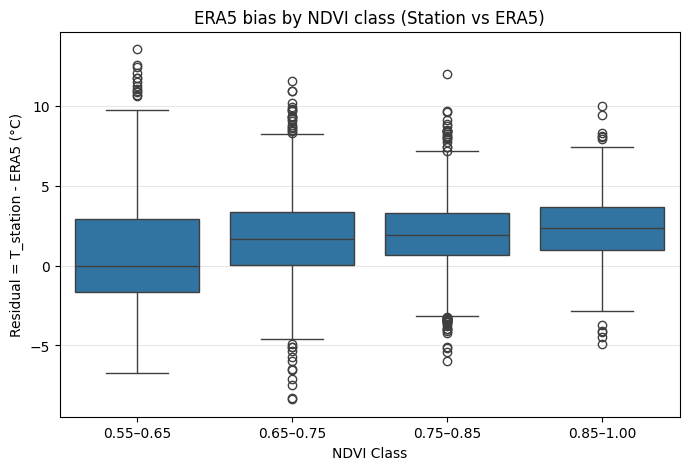

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="ndvi_class", y="residual")
plt.title("ERA5 bias by NDVI class (Station vs ERA5)")
plt.ylabel("Residual = T_station - ERA5 (°C)")
plt.xlabel("NDVI Class")
plt.grid(True, axis="y", alpha=0.3)
plt.show()


In [ ]:
summary = df.groupby("ndvi_class")["residual"].agg(
    mean_bias="mean",
    std="std",
    rmse=lambda x: (x**2).mean()**0.5,
    count="count"
).round(2)

summary


/tmp/ipython-input-2211054719.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby("ndvi_class")["residual"].agg(


,mean_bias,std,rmse,count
ndvi_class,,,,
0.55–0.65,1.04,3.57,3.71,576
0.65–0.75,1.74,2.43,2.99,1822
0.75–0.85,1.96,2.06,2.85,2175
0.85–1.00,2.31,2.03,3.08,947


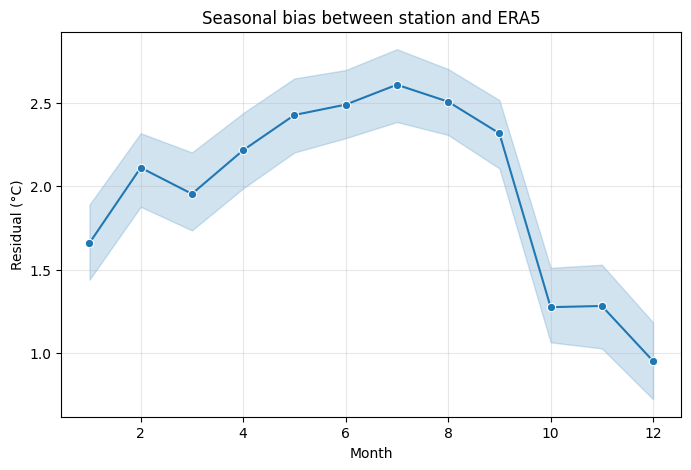

In [ ]:
df["month"] = df["date"].dt.month

plt.figure(figsize=(8,5))
sns.lineplot(data=df, x="month", y="residual", marker="o")
plt.title("Seasonal bias between station and ERA5")
plt.xlabel("Month")
plt.ylabel("Residual (°C)")
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
import numpy as np
import os

print(df.columns)

# 1) ERA5 da Kelvin a °C
df["t_era5_c"] = df["t2m"] - 273.15

# 2) NDVI da 0–255 a 0–1
print(df["ndvi_raw"].describe())  # abbiamo visto max ~231
df["ndvi"] = df["ndvi_raw"] / 255.0

# 3) Residuo stazione - ERA5
df["residual"] = df["t_station"] - df["t_era5_c"]

# 4) Stagione semplificata
month = df["date"].dt.month

df["season"] = np.select(
    [
        month.isin([12, 1, 2]),   # inverno
        month.isin([3, 4, 5]),    # primavera
        month.isin([6, 7, 8]),    # estate
        month.isin([9, 10, 11]),  # autunno
    ],
    ["winter", "spring", "summer", "autumn"],
    default="unknown"            # 👈 evita il TypeError
)

print(df["season"].value_counts())
'''
# 5) Salva per riuso
out_path = os.path.join(base_main, "master_era5_station_ndvi.parquet")
df.to_parquet(out_path)
print("Saved to:", out_path)
'''
df.head()


Index(['date', 't_station', 't2m', 'ndvi_raw', 'station_id', 'lat', 'lon',
       'alt', 't2m_c', 'residual', 'ndvi', 'ndvi_class', 'month'],
      dtype='object')
count    6661.000000
mean      181.842366
std        33.994096
min        49.000000
25%       166.000000
50%       185.000000
75%       203.000000
max       235.000000
Name: ndvi_raw, dtype: float64
season
autumn    1745
spring    1656
summer    1653
winter    1607
Name: count, dtype: int64


,date,t_station,t2m,ndvi_raw,station_id,lat,lon,alt,t2m_c,residual,ndvi,ndvi_class,month,t_era5_c,season
0,2022-01-01,14.2,286.004791,168.0,017818,44.295278,10.428056,1150,12.854797,1.345203,0.658824,0.65–0.75,1,12.854797,winter
1,2022-01-02,10.6,281.696045,168.0,017818,44.295278,10.428056,1150,8.546051,2.053949,0.658824,0.65–0.75,1,8.546051,winter
2,2022-01-03,9.4,281.924500,168.0,017818,44.295278,10.428056,1150,8.774506,0.625494,0.658824,0.65–0.75,1,8.774506,winter
3,2022-01-04,8.4,281.684998,168.0,017818,44.295278,10.428056,1150,8.535004,-0.135004,0.658824,0.65–0.75,1,8.535004,winter
4,2022-01-05,8.0,281.132141,168.0,017818,44.295278,10.428056,1150,7.982147,0.017853,0.658824,0.65–0.75,1,7.982147,winter


In [ ]:
df.groupby(pd.cut(df["ndvi"], bins=10))["residual"].mean()


/tmp/ipython-input-705068713.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(pd.cut(df["ndvi"], bins=10))["residual"].mean()


,residual
ndvi,
"(0.191, 0.265]",NaN
"(0.265, 0.338]",NaN
"(0.338, 0.411]",NaN
"(0.411, 0.484]",1.373699
"(0.484, 0.557]",4.144131
"(0.557, 0.63]",3.040503
"(0.63, 0.703]",0.819935
"(0.703, 0.776]",2.219003
"(0.776, 0.849]",2.110005


In [ ]:
df.groupby("season")["residual"].agg(["mean", "std"])


,mean,std
season,,
autumn,1.633482,2.678892
spring,2.197880,2.530888
summer,2.533952,2.368161
winter,1.542755,2.623828


In [ ]:
df.groupby(pd.cut(df["lat"], bins=10))["residual"].mean()
df.groupby(pd.cut(df["alt"], bins=10))["residual"].mean()


/tmp/ipython-input-97676228.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(pd.cut(df["lat"], bins=10))["residual"].mean()
/tmp/ipython-input-97676228.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(pd.cut(df["alt"], bins=10))["residual"].mean()


,residual
alt,
"(-1.43, 143.0]",3.226707
"(143.0, 286.0]",1.656038
"(286.0, 429.0]",1.663398
"(429.0, 572.0]",3.369833
"(572.0, 715.0]",2.356499
"(715.0, 858.0]",NaN
"(858.0, 1001.0]",NaN
"(1001.0, 1144.0]",NaN
"(1144.0, 1287.0]",0.332870


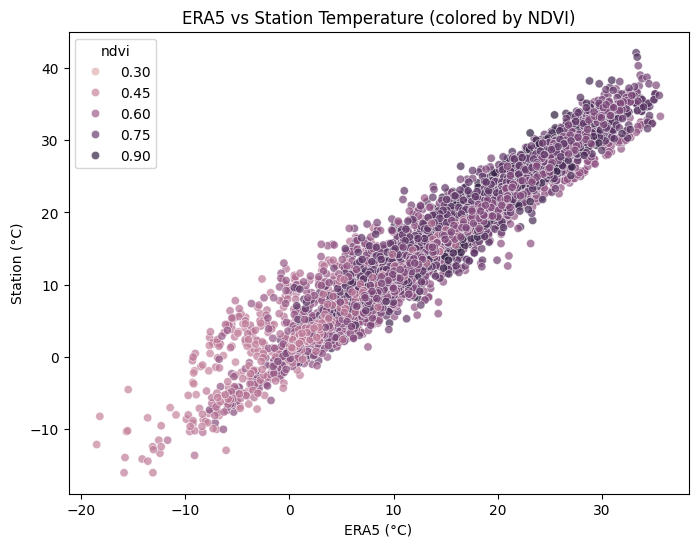

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="t_era5_c", y="t_station", hue="ndvi", alpha=0.7)
plt.xlabel("ERA5 (°C)")
plt.ylabel("Station (°C)")
plt.title("ERA5 vs Station Temperature (colored by NDVI)")
plt.show()


<Axes: xlabel='season', ylabel='residual'>

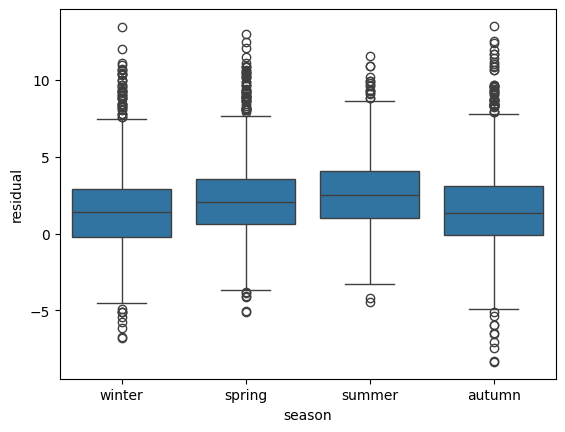

In [ ]:
sns.boxplot(data=df, x="season", y="residual")


Summrizing metrics

In [ ]:
def summary_stats(x):
    x = x.dropna()
    mean = x.mean()
    std = x.std()
    rmse = np.sqrt((x**2).mean())
    mae = x.abs().mean()
    ci95 = 1.96 * std / np.sqrt(len(x))
    return pd.Series({
        "mean": mean,
        "std": std,
        "rmse": rmse,
        "mae": mae,
        "ci95": ci95,
        "n": len(x),
    })

global_stats = summary_stats(df["residual"])
print(global_stats)


mean       1.971650
std        2.586752
rmse       3.252317
mae        2.528770
ci95       0.065596
n       5974.000000
dtype: float64


In [ ]:
'''
bins = [0.0, 0.2, 0.5, 1.0]
labels = ["low_veg (NDVI<0.2)", "mid_veg (0.2-0.5)", "high_veg (>0.5)"]
df["ndvi_class"] = pd.cut(df["ndvi"], bins=bins, labels=labels, include_lowest=True)
'''
df["ndvi_class"] = pd.qcut(df["ndvi"], q=3, labels=["low", "mid", "high"])


ndvi_stats = df.groupby("ndvi_class")["residual"].apply(summary_stats)
ndvi_stats


/tmp/ipython-input-808895601.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ndvi_stats = df.groupby("ndvi_class")["residual"].apply(summary_stats)


ndvi_class      
low         mean       1.381769
            std        3.463521
            rmse       3.727955
            mae        2.551057
            ci95       0.171000
            n       1576.000000
mid         mean       2.127707
            std        2.321645
            rmse       3.148807
            mae        2.547665
            ci95       0.091690
            n       2463.000000
high        mean       2.253451
            std        1.908057
            rmse       2.952430
            mae        2.486566
            ci95       0.085017
            n       1935.000000
Name: residual, dtype: float64

In [ ]:
season_stats = df.groupby("season")["residual"].apply(summary_stats)
season_stats


season      
autumn  mean       1.633482
        std        2.678892
        rmse       3.136899
        mae        2.329435
        ci95       0.132810
        n       1563.000000
spring  mean       2.197880
        std        2.530888
        rmse       3.351376
        mae        2.638122
        ci95       0.129293
        n       1472.000000
summer  mean       2.533952
        std        2.368161
        rmse       3.467749
        mae        2.862726
        ci95       0.121103
        n       1469.000000
winter  mean       1.542755
        std        2.623828
        rmse       3.043005
        mae        2.297486
        ci95       0.134132
        n       1470.000000
Name: residual, dtype: float64

In [ ]:
# ad esempio soglia 250 m
df["alt_class"] = np.where(df["alt"] < 250, "low_alt (<250m)", "high_alt (>=250m)")
alt_stats = df.groupby("alt_class")["residual"].apply(summary_stats)
alt_stats


alt_class              
high_alt (>=250m)  mean       1.663018
                   std        2.393057
                   rmse       2.913842
                   mae        2.394365
                   ci95       0.084874
                   n       3054.000000
low_alt (<250m)    mean       2.294445
                   std        2.738344
                   rmse       3.572176
                   mae        2.669342
                   ci95       0.099324
                   n       2920.000000
Name: residual, dtype: float64

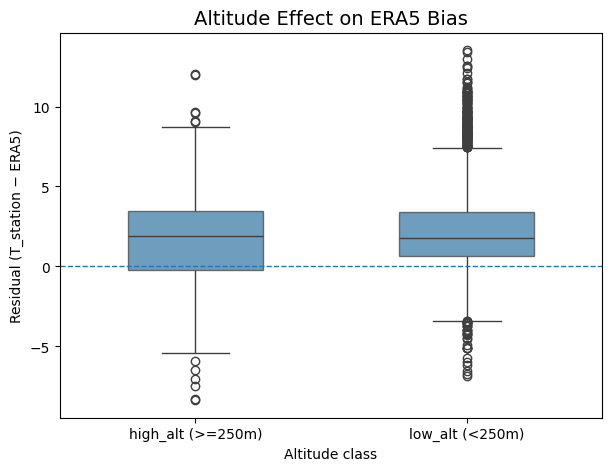

In [ ]:
plt.figure(figsize=(7,5))

sns.boxplot(
    data=df,
    x="alt_class",
    y="residual",
    width=0.5,
    boxprops=dict(alpha=0.7),
    showfliers=True
)

plt.axhline(0, linestyle="--", color="#1f77b4", linewidth=1)

plt.title("Altitude Effect on ERA5 Bias", fontsize=14)
plt.xlabel("Altitude class")
plt.ylabel("Residual (T_station − ERA5)")

plt.show()


In [ ]:
corr_vars = df[["residual", "ndvi", "alt", "lat", "lon"]].dropna()
corr_matrix = corr_vars.corr()
corr_matrix


,residual,ndvi,alt,lat,lon
residual,1.000000,0.021892,-0.346701,0.110818,-0.204136
ndvi,0.021892,1.000000,-0.119226,-0.344082,-0.209905
alt,-0.346701,-0.119226,1.000000,-0.478777,-0.137180
lat,0.110818,-0.344082,-0.478777,1.000000,0.379280
lon,-0.204136,-0.209905,-0.137180,0.379280,1.000000


<Figure size 600x400 with 0 Axes>

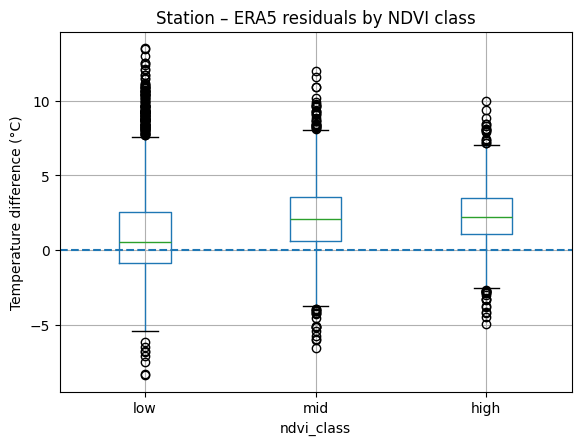

In [ ]:
plt.figure(figsize=(6,4))
df.boxplot(column="residual", by="ndvi_class")
plt.axhline(0, linestyle="--")
plt.title("Station – ERA5 residuals by NDVI class")
plt.suptitle("")
plt.ylabel("Temperature difference (°C)")
plt.show()


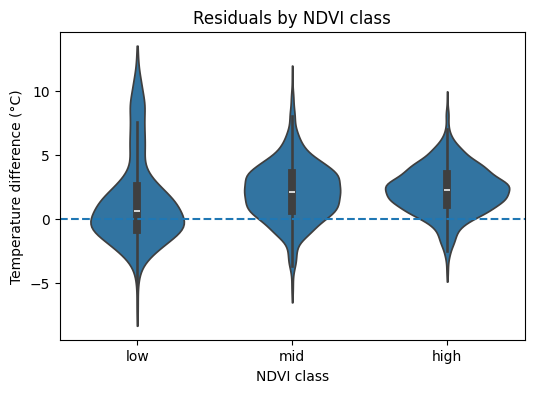

In [ ]:
import seaborn as sns

plt.figure(figsize=(6,4))
sns.violinplot(data=df, x="ndvi_class", y="residual", cut=0)
plt.axhline(0, linestyle="--")
plt.ylabel("Temperature difference (°C)")
plt.xlabel("NDVI class")
plt.title("Residuals by NDVI class")
plt.show()


<Figure size 400x400 with 0 Axes>

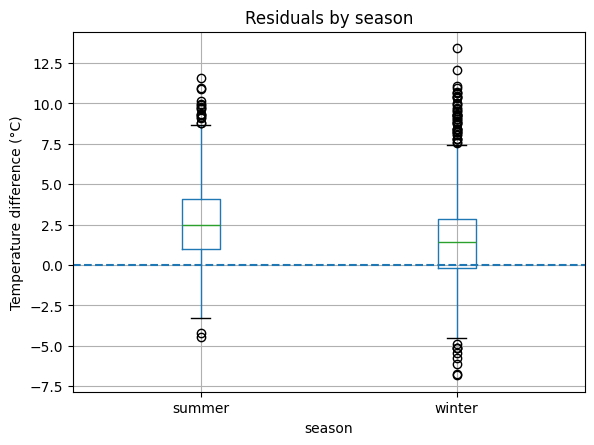

In [ ]:
plt.figure(figsize=(4,4))
df_season = df[df["season"].isin(["summer","winter"])]
df_season.boxplot(column="residual", by="season")
plt.axhline(0, linestyle="--")
plt.title("Residuals by season")
plt.suptitle("")
plt.ylabel("Temperature difference (°C)")
plt.show()


In [ ]:
df["coastal"] = np.where(df["lon"] < 0, "west/coastal-ish", "east/inland-ish")
coast_stats = df.groupby("coastal")["residual"].apply(summary_stats)
coast_stats


coastal               
east/inland-ish   mean       2.105484
                  std        2.562982
                  rmse       3.316715
                  mae        2.556058
                  ci95       0.071918
                  n       4879.000000
west/coastal-ish  mean       1.375324
                  std        2.609096
                  rmse       2.948335
                  mae        2.407182
                  ci95       0.154539
                  n       1095.000000
Name: residual, dtype: float64

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 1) Keep only rows without NaN in the main predictors
model_df = df[["residual", "ndvi", "alt", "lat", "lon", "season", "coastal"]].dropna()

X = model_df[["ndvi", "alt", "lat", "lon", "season", "coastal"]]
y = model_df["residual"]

numeric_features = ["ndvi", "alt", "lat", "lon"]
categorical_features = ["season", "coastal"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(drop="first"), categorical_features),
    ]
)

reg = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", LinearRegression())
    ]
)

reg.fit(X, y)

print("R^2:", reg.score(X, y))
coef = reg.named_steps["model"].coef_
intercept = reg.named_steps["model"].intercept_
print("Intercept:", intercept)
print("Coefs:", coef)


R^2: 0.3304967073543825
Intercept: 3.9052535773657366
Coefs: [-1.03685184e+00 -2.11610259e-03  3.85231429e-02 -1.94805498e-01
  5.01229029e-01  9.02136962e-01 -1.78539788e-01 -3.29468699e+00]


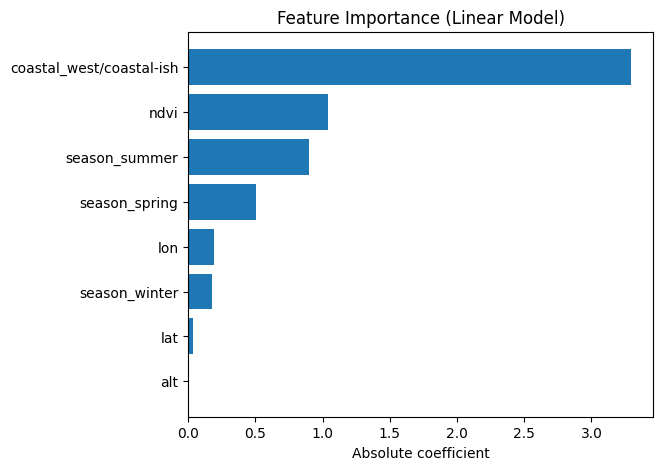

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get the model you already trained
model = reg.named_steps["model"]
encoder = reg.named_steps["preprocess"]

# Build feature names (numeric + one-hot)
numeric_features = ["ndvi", "alt", "lat", "lon"]
categorical_features = ["season", "coastal"]

# Get one-hot names
ohe = encoder.named_transformers_["cat"]
ohe_features = ohe.get_feature_names_out(categorical_features).tolist()

feature_names = numeric_features + ohe_features

coefs = model.coef_

# sort by absolute importance
idx = np.argsort(np.abs(coefs))[::-1]

plt.figure(figsize=(6,5))
plt.barh(np.array(feature_names)[idx], np.abs(coefs)[idx])
plt.xlabel("Absolute coefficient")
plt.title("Feature Importance (Linear Model)")
plt.gca().invert_yaxis()
plt.show()


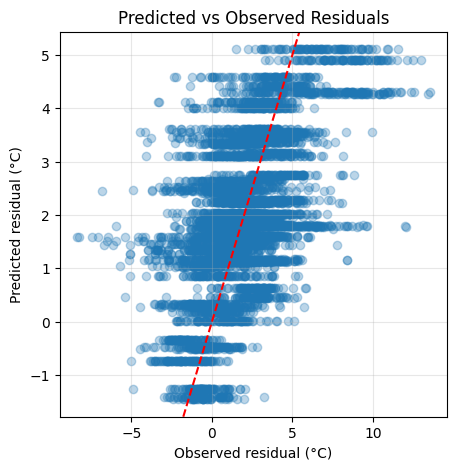

In [ ]:
y_pred = reg.predict(X)

plt.figure(figsize=(5,5))
plt.scatter(y, y_pred, alpha=0.3)
plt.xlabel("Observed residual (°C)")
plt.ylabel("Predicted residual (°C)")
plt.title("Predicted vs Observed Residuals")
plt.axline((0,0),(1,1), color="red", linestyle="--")
plt.grid(True, alpha=0.3)
plt.show()
